# Learning Rate Schedules

### Changing the Learning Rate _over time_

## Constant learning rate

$$\theta_{j+1} = \theta_{j} - \alpha  J'(\theta_{j})$$

$$\alpha = \text{learning rate}$$

<center><img src="https://cdn-images-1.medium.com/max/1600/0*uIa_Dz3czXO5iWyI." width="600px"/></center>

## Changing learning rate _over time_ with Schedules

$$\theta_{j+1} = \theta_{j} - \alpha_{j}  J'(\theta_{j})$$

$$\alpha_{j} = \text{learning rate at iteration } j$$

__Schedules__ define how the learning rate changes over time.

Specified for each epoch or iteration (i.e. batch) of training.

Can be used to overcome speed vs performance tradeoff.

## Same as adaptive methods?

Schedules differ from adaptive methods (such as AdaDelta and Adam) because they:

* change the global learning rate for the optimizer, rather than parameter-wise learning rates
* don't take feedback from the training process and are specified beforehand

In [1]:
%matplotlib inline
from __future__ import print_function
import math
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
import numpy as np

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
def plot_schedule(schedule_fn, iterations=1500):
    # Iteration count starting at 1
    iterations = [i+1 for i in range(iterations)]
    lrs = [schedule_fn(i) for i in iterations]
    plt.figure(figsize=(8,6))
    plt.scatter(iterations, lrs)
    plt.xlabel("Iteration", fontsize=18)
    plt.ylabel("Learning Rate", fontsize=18)
    plt.show() 

## Stepwise Decay Schedules

### `FactorScheduler` in `mxnet.lr_scheduler`

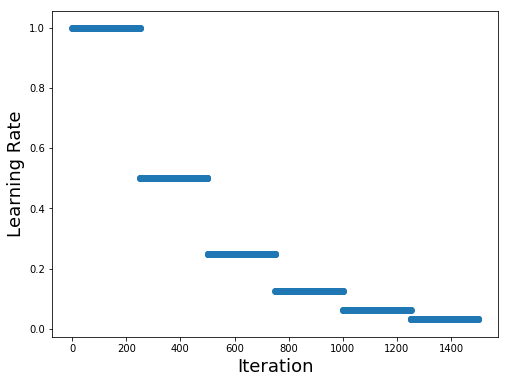

In [3]:
schedule = mx.lr_scheduler.FactorScheduler(step=250, factor=0.5)
schedule.base_lr = 1
plot_schedule(schedule)

### `MultiFactorScheduler`  in `mxnet.lr_scheduler`

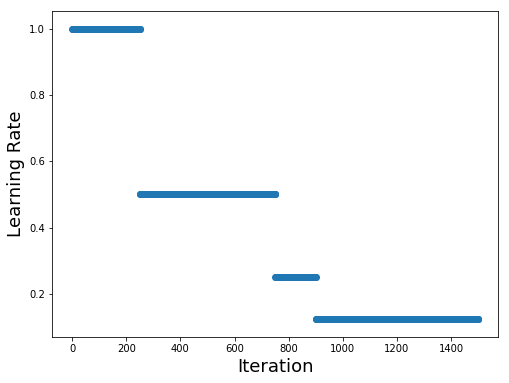

In [4]:
schedule = mx.lr_scheduler.MultiFactorScheduler(step=[250, 750, 900], factor=0.5)
schedule.base_lr = 1
plot_schedule(schedule)

## Polynomial Schedule

### `PolyScheduler`  in `mxnet.lr_scheduler`

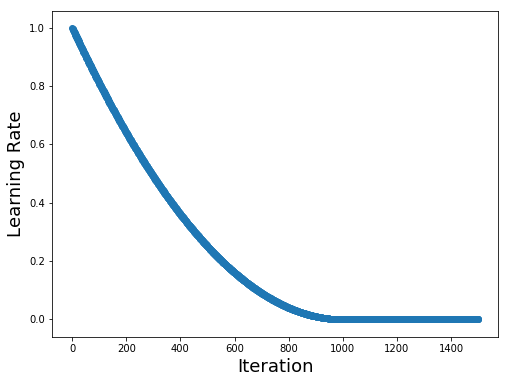

In [5]:
schedule = mx.lr_scheduler.PolyScheduler(max_update=1000, base_lr=1, pwr=2)
plot_schedule(schedule)

## Custom Schedules

In [6]:
class CosineAnnealingSchedule():
    def __init__(self, min_lr, max_lr, cycle_length):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length:
            unit_cycle = (1 + math.cos(iteration * math.pi / self.cycle_length)) / 2
            adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
            return adjusted_cycle
        else:
            return self.min_lr

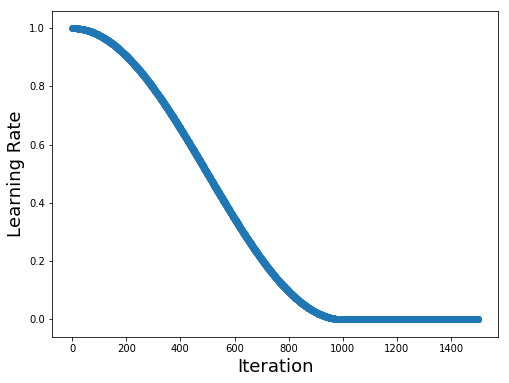

In [7]:
schedule = CosineAnnealingSchedule(min_lr=0, max_lr=1, cycle_length=1000)
plot_schedule(schedule)

# Using Schedules

In [8]:
# Use GPU if one exists, else use CPU
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()

# MNIST images are 28x28. Total pixels in input layer is 28x28 = 784
num_inputs = 784
# Clasify the images into one of the 10 digits
num_outputs = 10
# 64 images in a batch
batch_size = 64

# Load the training data
train_dataset = mx.gluon.data.vision.MNIST(train=True).transform_first(transforms.ToTensor())
train_dataloader = mx.gluon.data.DataLoader(train_dataset, batch_size, shuffle=True) 

In [9]:
# Build a simple convolutional network
def build_cnn():
    net = nn.HybridSequential()
    with net.name_scope():
        # First convolution
        net.add(nn.Conv2D(channels=10, kernel_size=5, activation='relu'))
        net.add(nn.MaxPool2D(pool_size=2, strides=2))
        # Second convolution
        net.add(nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
        net.add(nn.MaxPool2D(pool_size=2, strides=2))
        # Flatten the output before the fully connected layers
        net.add(nn.Flatten())
        # First fully connected layers with 512 neurons
        net.add(nn.Dense(512, activation="relu"))
        # Second fully connected layer with as many neurons as the number of classes
        net.add(nn.Dense(num_outputs))
        return net

In [10]:
net = build_cnn()
#Initialize the parameters with Xavier initializer
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
# Use cross entropy loss
softmax_cross_entropy = mx.gluon.loss.SoftmaxCrossEntropyLoss()

### Epochs to Iterations

In [11]:
steps_epochs = [4, 7, 9]
# assuming we keep partial batches, see `last_batch` parameter of DataLoader
iterations_per_epoch = math.ceil(len(train_dataset) / batch_size)
# iterations just before starts of epochs (iterations are 1-indexed)
steps_iterations = [s*iterations_per_epoch for s in steps_epochs]
print("Learning rate drops after iterations: {}".format(steps_iterations))

Learning rate drops after iterations: [3752, 6566, 8442]


###  `Optimizer`'s `lr_scheduler` parameter:

In [12]:
schedule = mx.lr_scheduler.MultiFactorScheduler(step=steps_iterations, factor=0.1)

In [13]:
sgd_optimizer = mx.optimizer.SGD(learning_rate=0.03, lr_scheduler=schedule)

In [14]:
trainer = mx.gluon.Trainer(params=net.collect_params(), optimizer=sgd_optimizer)

### Usual training loop

In [15]:
num_epochs = 10
# epoch and batch counts starting at 1
for epoch in range(1, num_epochs+1):
    # Iterate through the images and labels in the training data
    for batch_num, (data, label) in enumerate(train_dataloader, start=1):
        # get the images and labels
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        # Ask autograd to record the forward pass
        with mx.autograd.record():
            # Run the forward pass
            output = net(data)
            # Compute the loss
            loss = softmax_cross_entropy(output, label)
        # Compute gradients
        loss.backward()
        # Update parameters
        trainer.step(data.shape[0])

        # Show loss and learning rate after first iteration of epoch
        if batch_num == 1:
            curr_loss = mx.nd.mean(loss).asscalar()
            curr_lr = trainer.learning_rate
            print("Epoch: %d; Batch %d; Loss %f; LR %f" % (epoch, batch_num, curr_loss, curr_lr))

Epoch: 1; Batch 1; Loss 2.314107; LR 0.030000
Epoch: 2; Batch 1; Loss 0.280223; LR 0.030000
Epoch: 3; Batch 1; Loss 0.195433; LR 0.030000
Epoch: 4; Batch 1; Loss 0.026447; LR 0.030000
Epoch: 5; Batch 1; Loss 0.033129; LR 0.003000
Epoch: 6; Batch 1; Loss 0.030442; LR 0.003000
Epoch: 7; Batch 1; Loss 0.026779; LR 0.003000
Epoch: 8; Batch 1; Loss 0.043096; LR 0.000300
Epoch: 9; Batch 1; Loss 0.009633; LR 0.000300
Epoch: 10; Batch 1; Loss 0.006982; LR 0.000030


## Manually setting the learning rate: Gluon API only

In [ ]:
net = build_cnn()
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

schedule = mx.lr_scheduler.MultiFactorScheduler(step=steps_iterations, factor=0.1)
schedule.base_lr = 0.03
sgd_optimizer = mx.optimizer.SGD()
trainer = mx.gluon.Trainer(params=net.collect_params(), optimizer=sgd_optimizer)

In [17]:
iteration_idx = 1
num_epochs = 10
# epoch and batch counts starting at 1
for epoch in range(1, num_epochs + 1):
    # Iterate through the images and labels in the training data
    for batch_num, (data, label) in enumerate(train_dataloader, start=1):
        # get the images and labels
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        # Ask autograd to record the forward pass
        with mx.autograd.record():
            # Run the forward pass
            output = net(data)
            # Compute the loss
            loss = softmax_cross_entropy(output, label)
        # Compute gradients
        loss.backward()
        # Update the learning rate
        lr = schedule(iteration_idx)
        trainer.set_learning_rate(lr)
        # Update parameters
        trainer.step(data.shape[0])
        # Show loss and learning rate after first iteration of epoch
        if batch_num == 1:
            curr_loss = mx.nd.mean(loss).asscalar()
            curr_lr = trainer.learning_rate
            print("Epoch: %d; Batch %d; Loss %f; LR %f" % (epoch, batch_num, curr_loss, curr_lr))
        iteration_idx += 1

Epoch: 1; Batch 1; Loss 2.303522; LR 0.030000
Epoch: 2; Batch 1; Loss 0.038703; LR 0.030000
Epoch: 3; Batch 1; Loss 0.017371; LR 0.030000
Epoch: 4; Batch 1; Loss 0.067502; LR 0.030000
Epoch: 5; Batch 1; Loss 0.017181; LR 0.003000
Epoch: 6; Batch 1; Loss 0.006709; LR 0.003000
Epoch: 7; Batch 1; Loss 0.090532; LR 0.003000
Epoch: 8; Batch 1; Loss 0.031328; LR 0.000300
Epoch: 9; Batch 1; Loss 0.100414; LR 0.000300
Epoch: 10; Batch 1; Loss 0.024950; LR 0.000030


# State-of-the-art Schedules in the next video!